In [6]:
#!pip install 'shimmy>=2.0'
#!pip install stable_baselines3

In [11]:
import gym
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import spaces
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.shares_held = 0
        self.net_worth = initial_balance
        self.max_steps = len(df) - 1
        self.total_profit = 0
        self.trades = 0
        self.winning_trades = 0
        self.transaction_log = []

        # Define action space: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.df.columns),), dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.total_profit = 0
        self.trades = 0
        self.winning_trades = 0
        self.transaction_log = []
        return self._get_observation()

    def _get_observation(self):
        return self.df.iloc[self.current_step].values

    def step(self, action):
        current_price = self.df.loc[self.current_step, "Close"]
        reward = 0

        transaction_cost = 0.001

        if action == 1:  # Buy
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price * (1 + transaction_cost)
        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price * (1 - transaction_cost)
                self.trades += 1
                if current_price > self.df.loc[self.current_step - 1, "Close"]:
                    self.winning_trades += 1

        self.net_worth = self.balance + self.shares_held * current_price

        reward = self.net_worth - self.initial_balance
        if reward < 0:
            reward *= 0.5

        if self.current_step > 0 and current_price < self.df.loc[self.current_step - 1, "Close"]:
            reward -= 1

        self.transaction_log.append({
            "Step": self.current_step,
            "Action": action,
            "Balance": self.balance,
            "Net Worth": self.net_worth,
            "Shares Held": self.shares_held,
            "Reward": reward
        })

        self.current_step += 1
        done = self.current_step >= self.max_steps
        obs = self._get_observation()

        return obs, reward, done, {}

    def save_transaction_log(self, filename="trading_log.csv"):
        df_log = pd.DataFrame(self.transaction_log)
        df_log.to_csv(filename, index=False)


In [ ]:
file_path = '/content/Gold2.csv'
data = pd.read_csv(file_path)
data = data.rename(columns={"Close/Last": "Close"})
data = data.drop(columns=["Unnamed: 0", "Volume", "Open", "High", "Low", "day", "month", "year"], errors='ignore')

In [ ]:
data = (data - data.mean()) / data.std()
env = DummyVecEnv([lambda: StockTradingEnv(data)])

model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    learning_rate=0.0003,
    gamma=0.99,
    n_steps=2048,
    ent_coef=0.01,
    clip_range=0.2,
)
model.learn(total_timesteps=50000)

In [12]:
# Evaluation
test_env = StockTradingEnv(data)
obs = test_env.reset()
done = False

rewards = []
net_worths = []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    rewards.append(reward)
    net_worths.append(test_env.net_worth)

test_env.save_transaction_log("trading_log.csv")

total_profit = test_env.net_worth - test_env.initial_balance
win_rate = (test_env.winning_trades / test_env.trades * 100) if test_env.trades > 0 else 0
sharpe_ratio = (np.mean(data['Close'].pct_change()) / np.std(data['Close'].pct_change())) * np.sqrt(252)
final_balance = test_env.net_worth

print(f"Total Profit: ${total_profit:.2f}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Final Balance: ${final_balance:.2f}")


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Profit: $255.77
Win Rate: 54.10%
Sharpe Ratio: 0.17
Final Balance: $10255.77


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


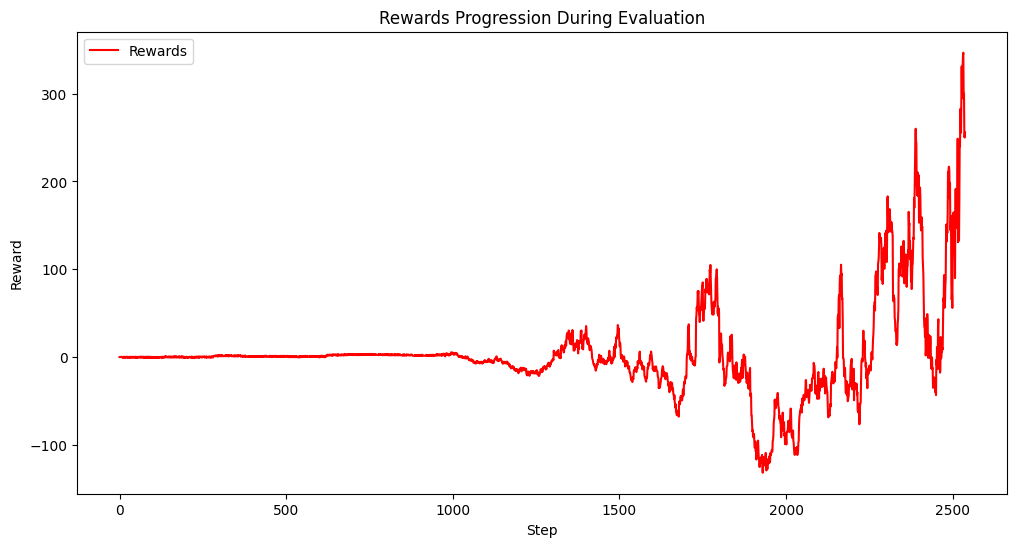

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Rewards', color='red')
plt.title('Rewards Progression During Evaluation')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()


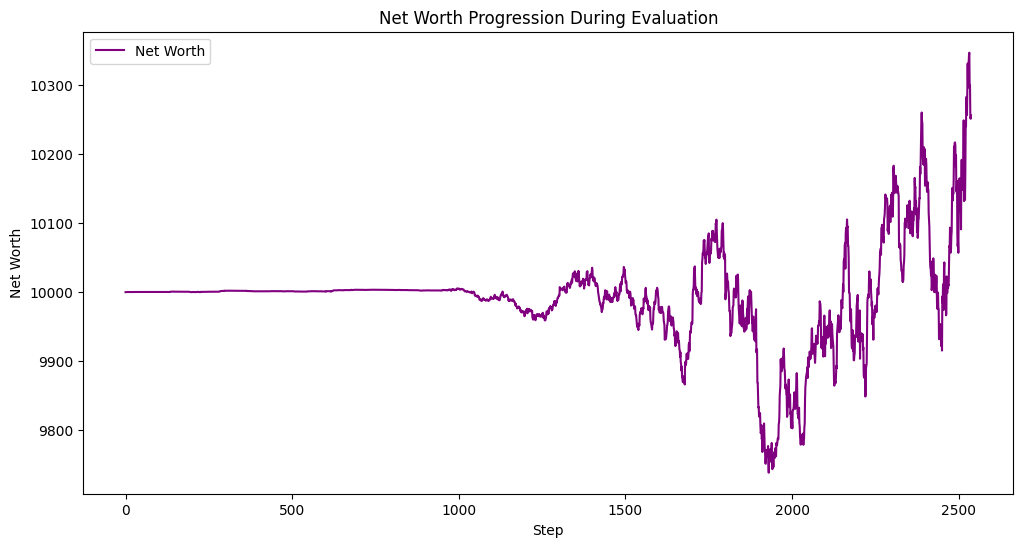

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(net_worths, label='Net Worth', color='purple')
plt.title('Net Worth Progression During Evaluation')
plt.xlabel('Step')
plt.ylabel('Net Worth')
plt.legend()
plt.show()